## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

## use camera calibration, test undistort and save result with pickle

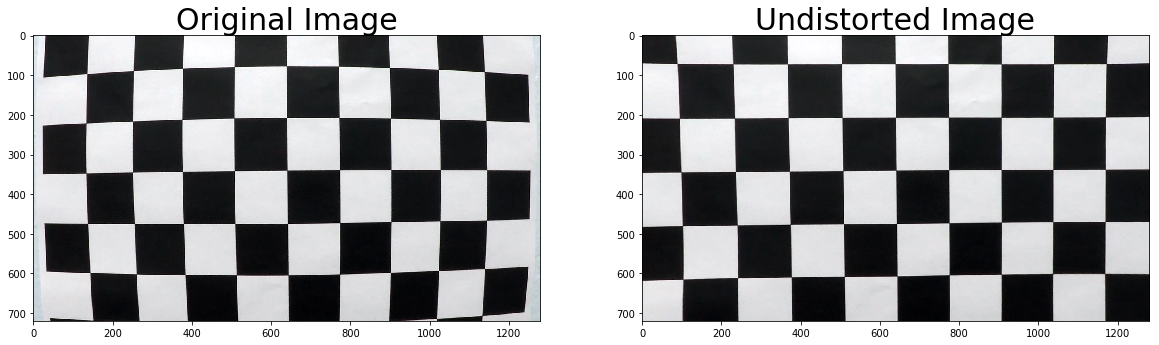

In [15]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Correct Distorted Image

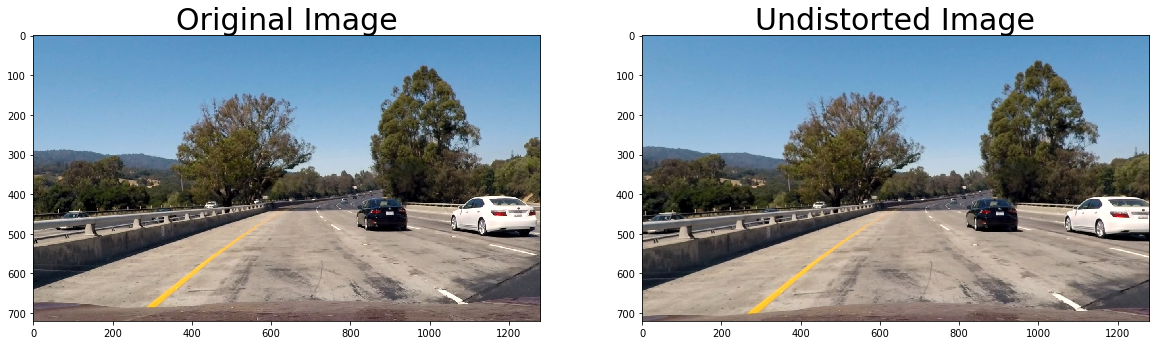

In [4]:
# Test undistortion on an image
img = cv2.imread('../test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

undistimg = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../camera_cal/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
undistimg = cv2.cvtColor(undistimg, cv2.COLOR_BGR2RGB)
ax2.imshow(undistimg)
ax2.set_title('Undistorted Image', fontsize=30)

# Create thresholded binary image

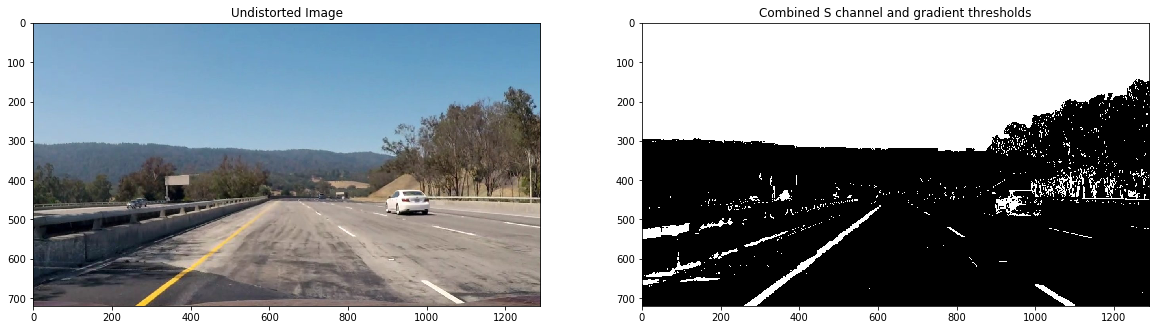

In [330]:


def thresholded_binary_image(img, gx_thresh, s_thresh):
    img_size = (img.shape[1], img.shape[0])

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    #gx_thresh[0] = 40
    #gx_thresh[1] = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= gx_thresh[0]) & (scaled_sobel <= gx_thresh[1])] = 1

    # Threshold color channel
    #s_thresh[0] = 200
    #s_thresh[1] = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
#img = cv2.imread('../test_images/test1.jpg')
#img = cv2.imread('road_wo_lines.jpg')
img = cv2.imread('whiteroad.jpg')

undistimg = cv2.undistort(img, mtx, dist, None, mtx)

gx_thresh=[40,100]
s_thresh=[90,255]

combined_binary=thresholded_binary_image(undistimg,gx_thresh,s_thresh)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Perspective Transform

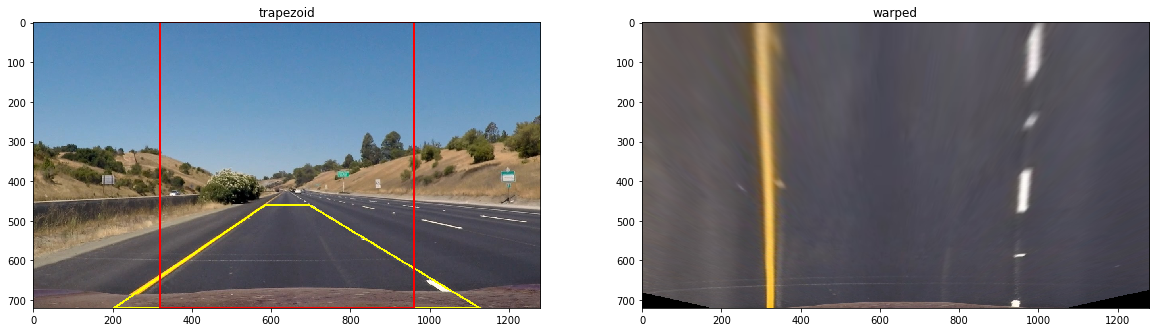

In [311]:
def warp(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    bottom_left=[200,img_size[1]]
    top_left=[(img_size[0]/2)-40,(img_size[1]/2)+100]
    top_right=[(img_size[0]/2)+70,(img_size[1]/2)+100]
    bottom_right=[1180,img_size[1]]

    ptsrect = np.array([top_left,top_right,bottom_right,bottom_left], np.int32)

    #img2 = np.copy(img)
    #cv2.polylines(img2, [ptsrect], True, (0,255,255), 3)


    #src = np.float32([top_left,top_right,bottom_right,bottom_left])
    
    offset = 10;


    #dst=np.float32([[top_left[0]-160,top_left[1]-top_left[1]+1 ],
     #               [top_right[0]+200,top_right[1]-top_left[1]+1],
     #               [bottom_right[0]-250 ,bottom_right[1] ],
     #               [bottom_left[0]+140 , bottom_left[1]]])
        
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

#img = cv2.imread('../test_images/test2.jpg')
img = cv2.imread('../test_images/straight_lines1.jpg')
#img = cv2.imread('road_wo_lines.jpg')
#img = cv2.imread('whiteroad.jpg')
undistimg = cv2.undistort(img, mtx, dist, None, mtx)

warped_img = warp(undistimg)

bottom_left=[200,img_size[1]]
top_left=[(img_size[0]/2)-40,(img_size[1]/2)+100]
top_right=[(img_size[0]/2)+70,(img_size[1]/2)+100]
bottom_right=[1180,img_size[1]]

ptsrect = np.array([top_left,top_right,bottom_right,bottom_left], np.int32)


dstrect=np.array([ [top_left[0]-160,top_left[1]-top_left[1]+1],
                   [top_right[0]+200,top_right[1]-top_left[1]+1] ,
                   [bottom_right[0]-250 ,bottom_right[1]-1 ],
                   [bottom_left[0]+140 , bottom_left[1]-1]], np.int32)


src = np.int32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.int32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

cv2.polylines(img, [src], True, (0,255,255), 3)
cv2.polylines(img, [dst], True, (0,0,255), 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('trapezoid')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)

ax2.set_title('warped')
warped_img = cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)
ax2.imshow(warped_img)

# Perspective Transform with thresholded image

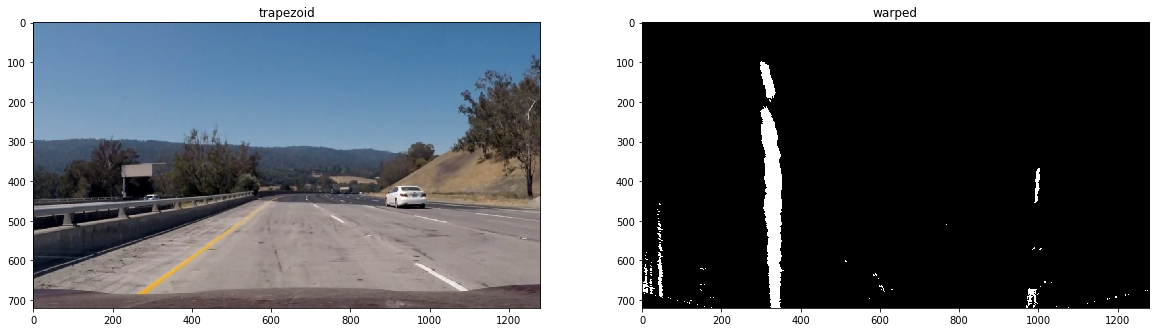

In [424]:
#img = cv2.imread('../test_images/test2.jpg')
#img = cv2.imread('../test_images/straight_lines1.jpg')
#img = cv2.imread('road_wo_lines.jpg')
img = cv2.imread('whiteroad2.jpg')

undistimg = cv2.undistort(img, mtx, dist, None, mtx)

warped_img = warp(undistimg)

gx_thresh=[40,100]
s_thresh=[70,255]

combined_binary=thresholded_binary_image(warped_img,gx_thresh,s_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('trapezoid')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)

ax2.set_title('warped')
#combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_BGR2RGB)
ax2.imshow(combined_binary, cmap='gray')


# Sliding window search

(720, 1280)


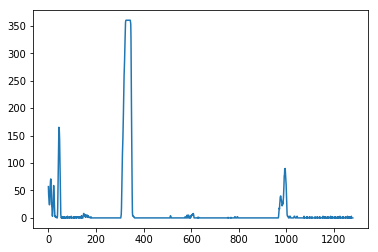

In [425]:

print(combined_binary.shape)
index=int(combined_binary.shape[0]/2)
histogram = np.sum(combined_binary[index:,:], axis=0)
plt.plot(histogram)

In [426]:
def sliding_windows_search(img):
    binary_warped=img
    midpointbw=int(img.shape[0]/2)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[midpointbw:,:], axis=0)
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        #print('left ',len(good_left_inds))
        #print('right', len(good_right_inds))

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds,right_lane_inds

def extract_pixel_positions(binary_warped,left_lane_inds,right_lane_inds):
    #print(len(left_lane_inds))
    #print(len(right_lane_inds))

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx,lefty,rightx,righty
    #print(len(lefty))
    #print(len(righty))
    
def get_poly_fit(leftx,lefty,rightx,righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit)
    #print(right_fit)
    return left_fit,right_fit


left_lane_inds,right_lane_inds = sliding_windows_search(combined_binary)

print(len(left_lane_inds))

    
leftx,lefty,rightx,righty = extract_pixel_positions(combined_binary, left_lane_inds,right_lane_inds)

left_fit,right_fit = get_poly_fit(leftx,lefty,rightx,righty)

19458


(720, 0)

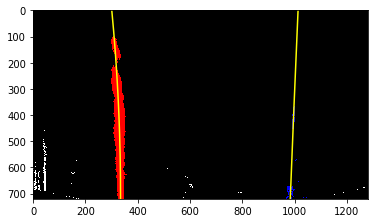

In [427]:
# Generate x and y values for plotting
def get_x_y_values_for_plot(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty,left_fitx,right_fitx

ploty,left_fitx,right_fitx = get_x_y_values_for_plot(combined_binary, left_fit, right_fit)
    
 # Create an output image to draw on and  visualize the result
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# skip sliding windows, you know where the line is

In [163]:
def search_line_wo_sliding_windows(img,left_fit,right_fit):
    binary_warped=img

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    #print(len(left_lane_inds))
    return left_lane_inds,right_lane_inds 
   
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    #return left_fit,right_fit

left_lane_inds,right_lane_inds = search_line_wo_sliding_windows(combined_binary,left_fit,right_fit)

leftx,lefty,rightx,righty = extract_pixel_positions(combined_binary, left_lane_inds,right_lane_inds)

left_fit,right_fit = get_poly_fit(leftx,lefty,rightx,righty)

316.027265582 0.0
395.680738783 719.0
829.615542398 0.0
934.877665726 719.0


(720, 0)

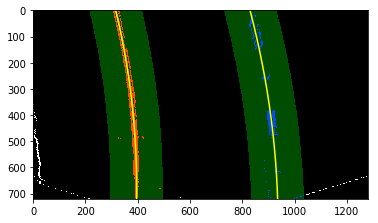

In [164]:
margin = 100

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

#print(ploty[ploty.shape[0]-1])

print(left_fitx[0],ploty[0])
print(left_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1])
#print(left_line_pts[0][int(left_line_pts.shape[1]/2)-1])

print(right_fitx[0],ploty[0])
print(right_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1])
#print(right_line_pts[0][right_line_pts.shape[1]-1])

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [400]:
#get angle in degreess
def get_line_slope_angle(pt1, pt2):
    #print(pt1,pt2)
    dx1 = pt1[0] - pt2[0]
    dy1 = pt1[1] - pt2[1]
    slope = dy1/dx1
    
    #print(-np.pi)
    #print(np.pi)
    
    angle = np.arctan(slope);
    #to degrees
    angle = angle*(180/np.pi)
    if angle < 0:
        angle = 180+angle
    #print(angle)
    #print(abs(angle)*(180/np.pi))
    return angle
    
angle_left = get_line_slope_angle([left_fitx[0],ploty[0]], 
                     [left_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]])

angle_right = get_line_slope_angle([right_fitx[0],ploty[0]],
                     [right_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]])

print(abs(angle_left-angle_right),'degrees')

9.08885063691 degrees


In [454]:
#angles in degree
def check_parallel_lines(angle_left, angle_right):
    #tolerance 5 degrees
    tolerance = 10
    diff = abs(angle_left-angle_right)
    
    #diff = 
    if abs(diff) <= tolerance:
        #print("equals slope")
        return True
    else:
        #print("not equals slope")
        return False
    
check_parallel_lines(angle_left, angle_right)

True

# Measuring curvature

In [353]:
y_eval = result.shape[0]
print(y_eval)
print(left_fit)
print(right_fit)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

720
[ -2.72990241e-05   5.90237237e-02   2.96684607e+02]
[ -4.59275350e-05  -3.00367657e-02   9.83679050e+02]
18326.3505057 11038.1030729


In [402]:
# Define conversions in x and y from pixels space to meters
def calc_curvature_in_m(img,lefty,leftx,righty,rightx):
    y_eval = img.shape[0]
    #print(y_eval)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #print(left_fit_cr)
    #print(right_fit_cr)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad,right_curverad

calc_curvature_in_m(out_img,lefty,leftx,righty,rightx)

(26487.044696441884, 1076.1793132766231)

# offset from lane center

In [403]:
def calc_offset(bottom_point_left, bottom_point_right):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    midbottom = int( (bottom_point_right[0] + bottom_point_left[0])/2)
    
    image_width = 1280
    
    midimage = int(image_width/2)
    
    #print(midbottom,midimage)
    
    midbottom = midbottom*xm_per_pix
    midimage = midimage*xm_per_pix
    
    offset = midimage - midbottom
    
    if offset < 0:
        #print(abs(offset),'r')
        return [abs(round(offset,3)),'r']
    elif offset > 0:
        #print(abs(offset),'l')
        return [abs(round(offset,3)),'l']
    else:
        #print(abs(offset),'c')
         return [abs(offset),'c']

calc_offset([left_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]],
            [right_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1] ] )

[0.005, 'r']

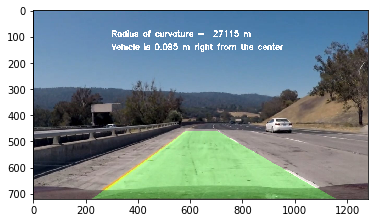

In [449]:
def project_lines(undistorted, binary_warped, ploty, left_fitx, right_fitx):
    warped = binary_warped
    img_size = (undistorted.shape[1], undistorted.shape[0])
    bottom_left=[200,img_size[1]]
    top_left=[(img_size[0]/2)-40,(img_size[1]/2)+100]
    top_right=[(img_size[0]/2)+70,(img_size[1]/2)+100]
    bottom_right=[1180,img_size[1]]
    
    #src = np.float32([top_left,top_right,bottom_right,bottom_left])

    #dst=np.float32([[top_left[0]-160,top_left[1]-top_left[1]+1 ],
    #                [top_right[0]+200,top_right[1]-top_left[1]+1],
    #                [bottom_right[0]-250 ,bottom_right[1] ],
    #                [bottom_left[0]+140 , bottom_left[1]]])
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

result = project_lines(img, combined_binary,ploty,left_fitx,right_fitx)

font = cv2.FONT_HERSHEY_SIMPLEX

curv_left, curv_right = calc_curvature_in_m(out_img,lefty,leftx,righty,rightx)

text = "Radius of curvature =  "+str(int((curv_left+curv_right)/2))+" m"
cv2.putText(result,text,(300,100), font, 1,(255,255,255),3)

offset = calc_offset([left_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]],
            [right_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1] ] )

if offset[1] == 'r':
    text = "Vehicle is "+str(offset[0])+" m right from the center"
    cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)
elif offset[1] == 'l':
    text = "Vehicle is "+str(offset[0])+" m left from the center"
    cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)
else:
    text = "Vehicle is "+str(offset[0])+" m from the center"
    cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)

plt.imshow(img)
plt.imshow(result)
    


# Imports

In [ ]:
import pickle
import numpy as np
import cv2

# Line Class

In [450]:
class Line():
    def __init__(self):
        #last n iterations
        self.itera = 1
        self.n = 10
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [451]:
global left_line_g, right_line_g
global mtx_g,dist_g
left_line_g = Line()
right_line_g = Line()

class MaxFrameError():
    def __init__(self):
        self.max_frame_error=0
        
class FirstRun():
    def __init__(self):
        self.first_run=True

global mfe
global fr

#frame errors
mfe = MaxFrameError()
mfe.max_frame_error=0
fr = FirstRun()
fr.first_run = True
#read calibration data
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx_g = dist_pickle["mtx"] 
dist_g = dist_pickle["dist"] 

print(fr.first_run)



True


In [455]:

def process_image(image):
    #global left_lines
    img = np.copy(image)
    error_tolerance = 5;
    #undistort image
    undistimg = cv2.undistort(img, mtx_g, dist_g, None, mtx_g)
    
    #warp image
    warped_img = warp(undistimg)
    
    gx_thresh=[40,100]
    s_thresh=[90,255]
    #create binary thresholded binary image
    binary_warped=thresholded_binary_image(warped_img,gx_thresh,s_thresh)
    
    left_lane_inds,right_lane_inds = sliding_windows_search(binary_warped)
    
        

    left_allx,left_ally,right_allx,right_ally = extract_pixel_positions(binary_warped, left_lane_inds,right_lane_inds)

      
    left_fit, right_fit = get_poly_fit(left_allx,left_ally,right_allx,right_ally)    
    
    ploty, left_fitx, right_fitx = get_x_y_values_for_plot(binary_warped, left_fit, right_fit)
    
    angle_left = get_line_slope_angle([left_fitx[0],ploty[0]], 
                     [left_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]])

    angle_right = get_line_slope_angle([right_fitx[0],ploty[0]],
                     [right_fitx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]])
    
    if check_parallel_lines(angle_left,angle_right):
        left_line_g.current_fit = left_fit
        right_line_g.current_fit = right_fit
    #check lines are nearly parallels
        left_line_g.allx,left_line_g.ally,right_line_g.allx,right_line_g.ally = left_allx,left_ally,right_allx,right_ally
    #    mfe.max_frame_errors += 1
        
    
        if left_line_g.itera < left_line_g.n:
            left_line_g.itera += 1
            right_line_g.itera += 1
            left_line_g.recent_xfitted.append(left_fitx)
            right_line_g.recent_xfitted.append(right_fitx)

            #left_line_g.current_fit.append(left_fit)
            #right_line_g.current_fit.append(right_fit)

        else:
            left_line_g.recent_xfitted.pop(0)
            right_line_g.recent_xfitted.pop(0)

            left_line_g.recent_xfitted.append(left_fitx)
            right_line_g.recent_xfitted.append(right_fitx)

            #left_line_g.current_fit.pop(0)
            #right_line_g.current_fit.pop(0)

            #left_line_g.current_fit.append(left_fit)
            #right_line_g.current_fit.append(right_fit)

        #average best fit    
        left_line_g.bestx = [sum(e)/len(e) for e in zip(*left_line_g.recent_xfitted)]
        right_line_g.bestx = [sum(e)/len(e) for e in zip(*right_line_g.recent_xfitted)]
    
    
    #left_line_g.best_fit = np.mean(left_line_g.current_fit, axis=0)
    #right_line_g.best_fit = np.mean(right_line_g.current_fit, axis=0)
          
    #print(left_line_g.best_fit)
    #print(type(left_fit))
    result = project_lines(undistimg, binary_warped,ploty,left_line_g.bestx,right_line_g.bestx)    
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    curv_left, curv_right = calc_curvature_in_m(result,left_line_g.allx,left_line_g.ally,right_line_g.allx,right_line_g.ally)

    text = "Radius of curvature =  "+str(int((curv_left+curv_right)/2))+" m"
    cv2.putText(result,text,(300,100), font, 1,(255,255,255),3)

    offset = calc_offset([left_line_g.bestx[ploty.shape[0]-1],ploty[ploty.shape[0]-1]],
                [right_line_g.bestx[ploty.shape[0]-1],ploty[ploty.shape[0]-1] ] )

    if offset[1] == 'r':
        text = "Vehicle is "+str(offset[0])+" m right from the center"
        cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)
    elif offset[1] == 'l':
        text = "Vehicle is "+str(offset[0])+" m left from the center"
        cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)
    else:
        text = "Vehicle is "+str(offset[0])+" m from the center"
        cv2.putText(result,text,(300,150), font, 1,(255,255,255),3)

        
    #left_lines.detected = True
    #print(img.shape)
    return result

#print(fr.first_run)

In [105]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [456]:
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 10min 13s, sys: 2.34 s, total: 10min 15s
Wall time: 2min 53s


In [457]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))